In [1]:
import numpy as np
from tifffile import imread
from glob import glob
import re
import nrrd
import tifffile
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
directory = "/data2/Data/f10542/"
# fname = "f10542_postfix_gad-405_vglut-647.ome.btf"
# file_path = "/home/tyler/Dropbox/data/20181127/f10542/f10542_postfix_gcamp.ome.btf"
# file_path = "/home/tyler/Dropbox/data/20181127/f10542/f10542_alive_isosbestic_gcamp_0004.ome.btf"
# file_path = directory + fname

get_num = re.compile(".*_zplane=(\d*).*\.mmap")
get_z = lambda x: int(get_num.search(x).group(1))
planes = glob(directory + "cnmf/f10542_zplane=*_els_*.mmap")
planes = sorted(planes, key=lambda a: get_z(a))
nZ = len(planes)
print(f"Number of planes: {nZ}")

Number of planes: 29


In [3]:
def prepare_shape(mytuple):
    """ This promotes the elements inside a shape into np.uint64. It is intended to prevent overflows
        with some numpy operations that are sensitive to it, e.g. np.memmap """
    if not isinstance(mytuple, tuple):
        raise Exception("Internal error: prepare_shape() passed a non-tuple")
    return tuple(map(lambda x: np.uint64(x), mytuple))

# from Caiman
def load_memmap(filename, mode='r'):
    """ Load a memory mapped file created by the function save_memmap
    Args:
        filename: str
            path of the file to be loaded
        mode: str
            One of 'r', 'r+', 'w+'. How to interact with files
    Returns:
        Yr:
            memory mapped variable
        dims: tuple
            frame dimensions
        T: int
            number of frames
    Raises:
        Exception "Unknown file extension"
    """
    if ('.mmap' in filename):
        # Strip path components and use CAIMAN_DATA/example_movies
        # TODO: Eventually get the code to save these in a different dir
        file_to_load = filename
        filename = os.path.split(filename)[-1]
        fpart = filename.split('_')[1:-1] # The filename encodes the structure of the map
        d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]
                                                   ), int(fpart[-5]), int(fpart[-1]), fpart[-3]
        Yr = np.memmap(file_to_load, mode=mode, shape=prepare_shape((
            d1 * d2 * d3, T)), dtype=np.float32, order=order)
        return (Yr, (d1, d2), T) if d3 == 1 else (Yr, (d1, d2, d3), T)
    else:
        logging.error("Unknown extension for file " + str(filename))
        raise Exception('Unknown file extension (should be .mmap)')

# verify good alignment

In [4]:
postfix_gcamp, header = nrrd.read(directory+"warped/postfix_gcamp.nrrd")
sumZ_postfix = postfix_gcamp.sum(0)

isosbestic_gcamp, header = nrrd.read(directory+"f10542_alive_isosbestic_gcamp_0004.nrrd")
sumZ_isosbestic = isosbestic_gcamp.sum(0)

In [7]:
postfix_gad, header = nrrd.read(directory+"warped/postfix_gad.nrrd")
sumZ_gad = postfix_gad.sum(0)
postfix_vglut, header = nrrd.read(directory+"warped/postfix_vglut.nrrd")
sumZ_vglut = postfix_vglut.sum(0)

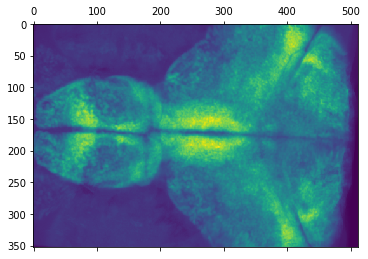

In [28]:
plt.matshow(sumZ_postfix)

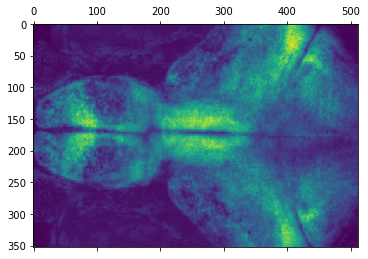

In [29]:
plt.matshow(sumZ_isosbestic)

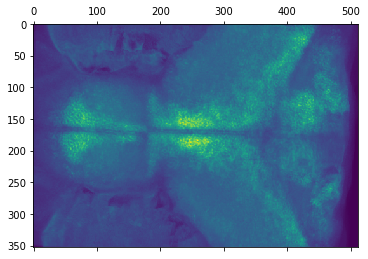

In [30]:
plt.matshow(sumZ_vglut)

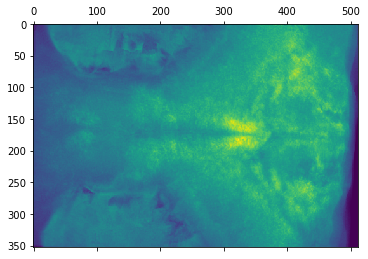

In [31]:
plt.matshow(sumZ_gad)

# Crop border

In [32]:
maxT_sumZ_plane = None
for z,pfile in enumerate(planes):
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')
    if maxT_sumZ_plane is None:
        maxT_sumZ_plane = plane.sum(axis=0)
    else:
        maxT_sumZ_plane += plane.sum(axis=0)

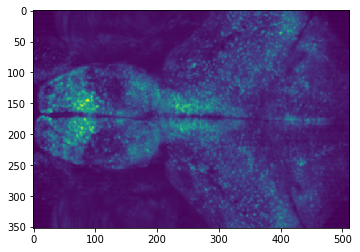

In [33]:
plt.imshow(maxT_sumZ_plane)

In [36]:
import matplotlib.patches as patches

sum 2975756500000.0
rect [0, 0, 350, 510]


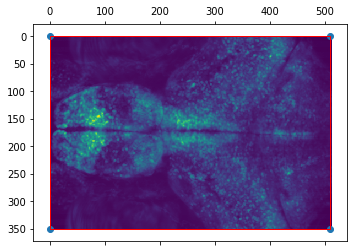

In [37]:
# crop so no nan
midH = maxT_sumZ_plane.shape[0]/2
midW = maxT_sumZ_plane.shape[1]/2
corners = np.zeros([4,2],dtype=int) # counter-clockwise
corners[1] = [maxT_sumZ_plane.shape[0]-1,0]
corners[2] = [maxT_sumZ_plane.shape[0]-1,maxT_sumZ_plane.shape[1]-1]
corners[3] = [0,maxT_sumZ_plane.shape[1]-1]

# find reasonable bounding box
i = 0
while np.isnan(maxT_sumZ_plane[corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum()):
    corners[0] += 1
    corners[1,0] -= 1
    corners[1,1] += 1
    corners[2] -= 1
    corners[3,0] += 1
    corners[3,1] -= 1
    i+= 1
    if i> 500:
        print("oops")
        break
print("sum", maxT_sumZ_plane[corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum())

# TODO improve by adjusting x,y on corner-by-corner basis

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.matshow(maxT_sumZ_plane)

# Create largest Rectangle patch within corners
rect_y = max(corners[0,0],corners[3,0])
rect_x = max(corners[0,1],corners[1,1])
rect_H = min(corners[1,0]-corners[0,0], corners[2,0]-corners[3,0])
rect_W = min(corners[3,1]-corners[0,1], corners[2,1]-corners[1,1])
# make even for resizing
if rect_H % 2 == 1:
    rect_H -= 1
if rect_W % 2 == 1:
    rect_W -= 1
# make all four corners on rectangle
corners = np.array([ [rect_y,rect_x], [rect_y+rect_H, rect_x], [rect_y+rect_H, rect_x+rect_W], [rect_y, rect_x+rect_W] ])
print("rect",[rect_x,rect_y,rect_H, rect_W])
# flip for viz
rect = patches.Rectangle([rect_x, rect_y],rect_W,rect_H,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
    
# plt.figure()
# plt.scatter(*np.where(np.isnan(maxT_plane)))
ax.scatter(corners[:,1], corners[:,0],)

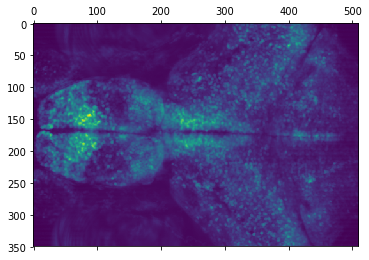

In [38]:
plt.matshow(maxT_sumZ_plane[corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]])

In [15]:
maxT_sumZ_crop = maxT_sumZ_plane[corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]]

In [39]:
corners

array([[  0,   0],
       [350,   0],
       [350, 510],
       [  0, 510]])

In [17]:
directory

'/data2/Data/f10542/'

In [40]:
# save corners
np.save(directory+"/cnmf/corners.npy", corners)

# Find xy shift
TODO: right now does no shift...

In [9]:
def pad_image(image, H, W):
    try:
        assert image.shape[0] <= H and image.shape[1] <= W
    except Exception as e:
        print("H ({}) and W ({}) must be less than {} and {}".format(H, W, image.shape[0], image.shape[1]))
        raise e
    new_image = np.zeros([H,W])
    if image.shape[0]==H:
        pad_top = False
    else:
        pad_top = int(np.ceil((H-image.shape[0])/2))
        pad_bottom = int(np.floor((H-image.shape[0])/2))
    if image.shape[0]==W:
        pad_left = False
    else:
        pad_left = int(np.ceil((W-image.shape[1])/2))
        pad_right = int(np.floor((W-image.shape[1])/2))
    if not pad_left and not pad_top:
        return image
    elif pad_left and not pad_top:
        new_image[:,pad_left:(-pad_right)] = image
    elif pad_top and not pad_left:
        new_image[pad_top:(-pad_bottom),:] = image
    else:
        new_image[pad_top:(-pad_bottom),pad_left:(-pad_right)] = image
    return new_image.astype(np.float32)

def crop_image(image, H, W):
    try:
        assert image.shape[0] >= H and image.shape[1] >= W
    except Exception as e:
        print("H ({}) and W ({}) must be less than {} and {}".format(H, W, image.shape[0], image.shape[1]))
        raise e
    new_image = np.zeros([H,W])
    if image.shape[0]==H:
        crop_top = False
    else:
        crop_top = int(np.ceil((image.shape[0]-H)/2))
        crop_bottom = int(np.floor((image.shape[0]-H)/2))
    if image.shape[0]==W:
        crop_left = False
    else:
        crop_left = int(np.ceil((image.shape[1]-W)/2))
        crop_right = int(np.floor((image.shape[1]-W)/2))
    if not crop_left and not crop_top:
        return image
    elif crop_left and not crop_top:
        new_image = image[:,crop_left:(-crop_right)]
    elif crop_top and not crop_left:
        new_image = image[crop_top:(-crop_bottom),:]
    else:
        new_image = image[crop_top:(-crop_bottom),crop_left:(-crop_right)]
    return new_image.astype(np.float32)


def pad_volume(image, H, W):
    # this should be ND...
    try:
        assert image.shape[1] <= H and image.shape[2] <= W
    except Exception as e:
        print("H ({}) and W ({}) must be less than {} and {}".format(H, W, image.shape[1], image.shape[2]))
        raise e
    new_image = np.zeros([image.shape[0], H,W])
    if image.shape[1]==H:
        pad_top = False
    else:
        pad_top = int(np.ceil((H-image.shape[1])/2))
        pad_bottom = int(np.floor((H-image.shape[1])/2))
    if image.shape[1]==W:
        pad_left = False
    else:
        pad_left = int(np.ceil((W-image.shape[2])/2))
        pad_right = int(np.floor((W-image.shape[2])/2))
    if not pad_left and not pad_top:
        return image
    elif pad_left and not pad_top:
        new_image[:, :,pad_left:(-pad_right)] = image
    elif pad_top and not pad_left:
        new_image[:, pad_top:(-pad_bottom),:] = image
    else:
        new_image[:, pad_top:(-pad_bottom),pad_left:(-pad_right)] = image
    return new_image.astype(np.float32)

def norm01(a):
    return (a-a.min())/a.max()

# def shift_image(a,dW,dH):
#     new_a = np.zeros(*a.shape)
    

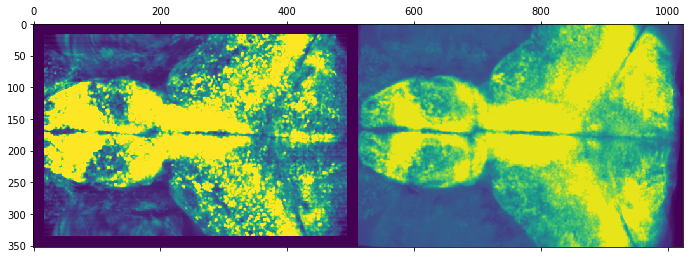

In [42]:
pad_functional = pad_image(norm01(maxT_sumZ_crop),352,512)
percent = 80
pad_functional[pad_functional>np.percentile(pad_functional,percent)] = np.percentile(pad_functional,percent)
norm_postfix = norm01(sumZ_postfix)
norm_postfix[norm_postfix>np.percentile(norm_postfix,percent)] = np.percentile(norm_postfix,percent)
equalized_postfix = norm_postfix/norm_postfix.sum()*1.25*pad_functional.sum()
plt.matshow(np.hstack([pad_functional,equalized_postfix]))

In [43]:
from itertools import product
H, W = sumZ_postfix.shape

pad_image(norm01(maxT_sumZ_crop),352,512)
MI = {k: mutual_information(pad_functional,np.roll(equalized_postfix,k)) for k in product(range(-10,10),range(-10,10))}
print(sorted(list(MI.values()),reverse=True)[:10])


func2D = pad_image(maxT_sumZ_crop,H, W)
fix2D = sumZ_postfix
MI = {k: mutual_information(func2D,np.roll(fix2D,k)) for k in product(range(-10,10),range(-10,10))}
print(sorted(list(MI.values()),reverse=True)[:10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


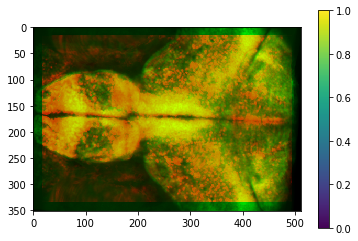

In [44]:
mix = np.zeros([*pad_functional.shape, 3])
mix[:,:,0] = pad_functional*5
norm_postfix = norm01(sumZ_postfix)
equalized_postfix = norm_postfix/norm_postfix.sum()*pad_functional.sum()
mix[:,:,1] = equalized_postfix*5
plt.imshow(mix)
plt.colorbar()

# Find z matching

In [11]:
# https://matthew-brett.github.io/teaching/mutual_information.html
def mutual_information(A, B):
    """ Mutual information for joint histogram
    """
    hgram, x_edges, y_edges = np.histogram2d(A.ravel(), B.ravel(), bins=20) 
    # Convert bins counts to probability values

    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [13]:
corners = np.load(directory+"/cnmf/corners.npy")

In [14]:
z = 0
pfile = planes[z]
Yr, dims, T = load_memmap(pfile)
plane = np.reshape(Yr.T, [T] + list(dims), order='F')
# sumT_pad_crop_plane = pad_volume(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]], H, W).sum(0)
sumT_pad_crop_plane = pad_image(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum(0), H, W)

In [15]:
crop_plane = plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum(0)
cropH, cropW = crop_plane.shape

In [47]:
nfixedZ = isosbestic_gcamp.shape[0]
mi_alive = np.zeros([nZ,nfixedZ])
mi_postfix = np.zeros([nZ,nfixedZ])
for z in range(nZ):
    pfile = planes[z]
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')
    sumT_crop_plane = plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum(0)
    for fixedZ in range(nfixedZ):
        mi_alive[z,fixedZ] = mutual_information(sumT_crop_plane,crop_image(isosbestic_gcamp[fixedZ],cropH, cropW))
        mi_postfix[z,fixedZ] = mutual_information(sumT_crop_plane,crop_image(postfix_gcamp[fixedZ],cropH, cropW))
        

In [48]:
# should be ascending with no duplicates
matching_alive = np.argmax(mi_alive,axis=1)
matching_alive

array([ 19,  22,  28,  33,  39,  43,  48,  54,  59,  64,  69,  74,  80,
        85,  90,  95, 101, 105, 110, 116, 121, 126, 131, 136, 139, 145,
       149, 156, 160])

In [49]:
# should be ascending with no duplicates (messier matching)
matching_fixed = np.argmax(mi_postfix,axis=1)
matching_fixed

array([ 18,  22,  28,  33,  38,  43,  48,  54,  60,  65,  70,  75,  80,
        85,  91,  96, 101, 106, 112, 117, 122, 126, 130, 136, 140, 144,
       150, 156, 160])

In [5]:
matching_fixed = np.array([ 18,  22,  28,  33,  38,  43,  48,  54,  60,  65,  70,  75,  80,
        85,  91,  96, 101, 106, 112, 117, 122, 126, 130, 136, 140, 144,
       150, 156, 160])

# save small volume using matching!

In [51]:
plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].shape

(5437, 350, 510)

In [16]:
# small_volume
# fig,ax = plt.subplots(5,5, figsize=(30,40))
i = 0
crop_isosbestic_gcamp = []
crop_postfix_gcamp = []
crop_postfix_gad = []
crop_postfix_vglut = []
small_imaging = None
for z, fixedZ in enumerate(matching_alive):
    print(z)
    pfile = planes[z]
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]]
    small_plane = resize_volume(plane, 0.5, 0.5)
    if small_imaging is None:
        small_imaging = np.zeros([small_plane.shape[0], nZ, *small_plane.shape[1:]])
    small_imaging[:,z] = small_plane
    
for z, fixedZ in enumerate(matching_fixed):
    crop_isosbestic_gcamp.append(crop_image(isosbestic_gcamp[fixedZ],cropH, cropW))
    crop_postfix_gcamp.append(crop_image(postfix_gcamp[fixedZ],cropH, cropW))
    crop_postfix_gad.append(crop_image(postfix_gad[fixedZ],cropH, cropW))
    crop_postfix_vglut.append(crop_image(postfix_vglut[fixedZ],cropH, cropW))

crop_isosbestic_gcamp = resize_volume(np.array(crop_isosbestic_gcamp),0.5,0.5)
crop_postfix_gcamp = resize_volume(np.array(crop_postfix_gcamp),0.5,0.5)
crop_postfix_gad = resize_volume(np.array(crop_postfix_gad),0.5,0.5)
crop_postfix_vglut = resize_volume(np.array(crop_postfix_vglut),0.5,0.5)

In [18]:
crop_postfix_gcamp.shape

(29, 175, 255)

In [24]:
def pad_imaging(imaging, H, W):
    try:
        assert imaging.shape[2] <= H and imaging.shape[3] <= W
    except Exception as e:
        print("H ({}) and W ({}) must be greater than {} and {}".format(H, W, imaging.shape[2], imaging.shape[3]))
        raise e
    new_imaging = np.zeros([imaging.shape[0],imaging.shape[1],H,W])
    if imaging.shape[2]==H:
        pad_top = False
    else:
        pad_top = int(np.floor((H-imaging.shape[2])/2))
        pad_bottom = int(np.ceil((H-imaging.shape[2])/2))
    if imaging.shape[3]==W:
        pad_left = False
    else:
        pad_left = int(np.floor((W-imaging.shape[3])/2))
        pad_right = int(np.ceil((W-imaging.shape[3])/2))
        
    if not pad_right and not pad_bottom:
        return imaging
    elif pad_right and not pad_bottom:
        new_imaging[:,:,:,pad_left:(-pad_right)] = imaging
    elif pad_bottom and not pad_right:
        new_imaging[:,:,pad_top:(-pad_bottom),:] = imaging
    else:
        new_imaging[:,:,pad_top:(-pad_bottom),pad_left:(-pad_right)] = imaging
    return new_imaging.astype(np.float32)

def pad_volume(image, H, W):
    # this should be ND...
    try:
        assert image.shape[1] <= H and image.shape[2] <= W
    except Exception as e:
        print("H ({}) and W ({}) must be less than {} and {}".format(H, W, image.shape[1], image.shape[2]))
        raise e
    new_image = np.zeros([image.shape[0], H,W])
    if image.shape[1]==H:
        pad_top = False
    else:
        pad_top = int(np.floor((H-image.shape[1])/2))
        pad_bottom = int(np.ceil((H-image.shape[1])/2))
    if image.shape[1]==W:
        pad_left = False
    else:
        pad_left = int(np.floor((W-image.shape[2])/2))
        pad_right = int(np.ceil((W-image.shape[2])/2))
        
#     print(pad_top,pad_bottom, pad_left, pad_right)
    if not pad_right and not pad_bottom:
        return image
    elif pad_right and not pad_bottom:
        new_image[:, :,pad_left:(-pad_right)] = image
    elif pad_bottom and not pad_right:
        new_image[:, pad_top:(-pad_bottom),:] = image
    else:
        new_image[:, pad_top:(-pad_bottom),pad_left:(-pad_right)] = image
    return new_image.astype(np.float32)

In [72]:
pad_small_imaging = pad_imaging(small_imaging,256,256)
pad_small_imaging.shape

0 1


(5437, 29, 256, 256)

In [20]:
crop_isosbestic_gcamp.shape

(29, 175, 255)

In [25]:
pad_isosbestic_gcamp = pad_volume(crop_isosbestic_gcamp,256,256)
pad_postfix_gcamp = pad_volume(crop_postfix_gcamp,256,256)
pad_postfix_gad = pad_volume(crop_postfix_gad,256,256)
pad_postfix_vglut = pad_volume(crop_postfix_vglut,256,256)

In [23]:
pad_postfix_gcamp.shape

(29, 256, 256)

In [27]:
np.save(f"{directory}/cnmf/functional.npy", pad_small_imaging)
np.save(f"{directory}/cnmf/isosbestic_gcamp.npy",
    pad_isosbestic_gcamp)
np.save(f"{directory}/cnmf/postfix_gcamp.npy",
    pad_postfix_gcamp)
np.save(f"{directory}/cnmf/postfix_gad.npy",
    pad_postfix_gad)
np.save(f"{directory}/cnmf/postfix_vglut.npy",
    pad_postfix_vglut)

In [ ]:
pad_post

In [48]:
pad_isosbestic_gcamp.shape

(29, 256, 256)

In [49]:
pad_small_imaging.shape

(5437, 29, 256, 256)

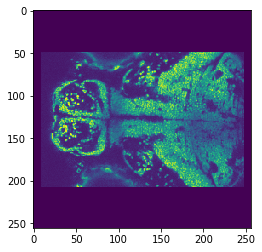

In [54]:
plt.imshow(pad_isosbestic_gcamp[10])

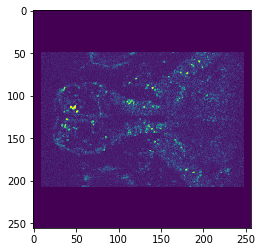

In [55]:
plt.imshow(pad_small_imaging[0,10])

# archive 

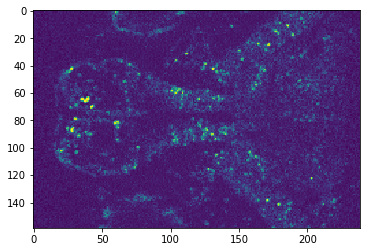

In [41]:
plt.imshow(small_imaging[0,10])

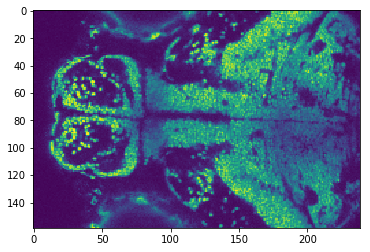

In [40]:
plt.imshow(crop_isosbestic_gcamp[10])

In [317]:
z=27
pfile = planes[z]
Yr, dims, T = load_memmap(pfile)
plane = np.reshape(Yr.T, [T] + list(dims), order='F')
# sumT_pad_crop_plane = pad_volume(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]], H, W).sum(0)
sumT_pad_crop_plane = pad_image(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum(0), H, W)

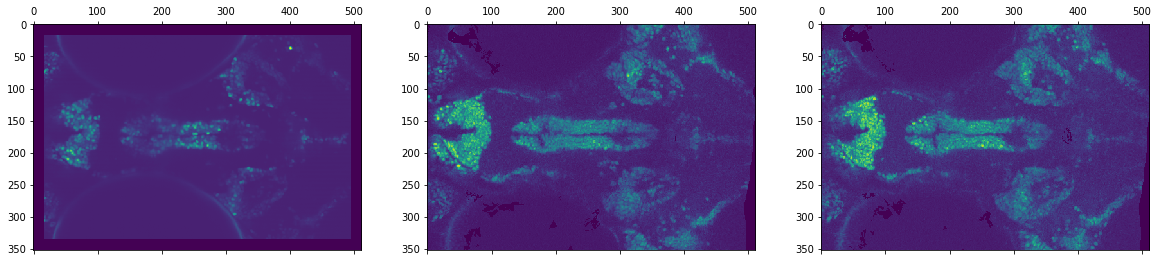

In [318]:
fig,ax = plt.subplots(1,3, figsize=(20,10))
ax[0].matshow(sumT_pad_crop_plane)
ax[1].matshow(postfix_gcamp[150])
ax[2].matshow(postfix_gcamp[155])

In [322]:
nfixedZ = isosbestic_gcamp.shape[0]
mi_alive = np.zeros([nZ,nfixedZ])
mi_postfix = np.zeros([nZ,nfixedZ])
for z in range(nZ):
    pfile = planes[z]
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')
    # sumT_pad_crop_plane = pad_volume(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]], H, W).sum(0)
    sumT_pad_crop_plane = pad_image(plane[:,corners[0,0]:corners[1,0],corners[0,1]:corners[3,1]].sum(0), H, W)
    for fixedZ in range(nfixedZ):
        mi_alive[z,fixedZ] = mutual_information(sumT_pad_crop_plane,isosbestic_gcamp[fixedZ])
        mi_postfix[z,fixedZ] = mutual_information(sumT_pad_crop_plane,postfix_gcamp[fixedZ])
        

In [38]:
diffH = postfix_gcamp.shape[1]-maxT_plane.shape[0]
diffW = postfix_gcamp.shape[2]-maxT_plane.shape[1]

In [47]:
halfH = int(diffH/2)
post_crop = postfix_gcamp[:,halfH:-halfH]

In [48]:
post_crop.shape

(241, 352, 512)

In [ ]:
mix = np.zeros([*alive[100].shape, 3])
mix[:,:,0] = (alive[100]-alive[100].min())/alive[100].max()
mix[:,:,1] = (post_gcamp[100]-post_gcamp[100].min())/post_gcamp[100].max()
plt.imshow(mix)

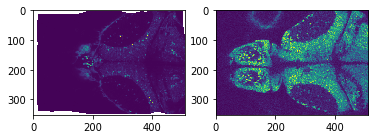

In [51]:
plt.subplot(1,2,1)
plt.imshow(maxT_plane)
plt.subplot(1,2,2)
plt.imshow(post_crop[60])

In [ ]:
mutual_information(maxT_plane, post_crop[0])

In [12]:
nfixedZ = postfix_gcamp.shape[0]
mi = np.zeros(nfixedZ)
for fixedZ in range(nfixedZ):
    mi[fixedZ] = mutual_information

small_images = None
for z,pfile in enumerate(planes):
    pfile = planes[z]
    Yr, dims, T = load_memmap(pfile)
    plane = np.reshape(Yr.T, [T] + list(dims), order='F')
    small_plane = resize_volume(plane, 0.5, 0.5)
    if small_images is None:
        # T x H x W
        shape = small_plane.shape
        small_images = np.zeros([shape[0],nZ,*shape[1:]])

    small_images[:,z] = small_plane

In [ ]:
small_images.shape

In [ ]:
plt.imshow(small_images[110,10])

In [ ]:
plt.imshow(small_images[110,20])

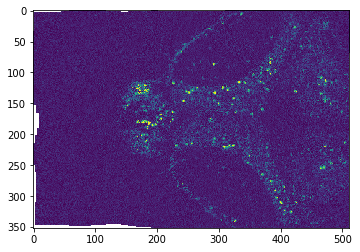

In [35]:
plt.imshow(images[109])

In [ ]:
# directory, fname = os.path.split(file_path)
name, ext = os.path.splitext(file_path)
name, ext2 = os.path.splitext(name)
ext = ext + ext2
tiff = tifffile.imread(file_path,)

# Z x T? x C? x X x Y
# where ? is optional and T is retakes ("time") and C is channel eg gad or vglut
tiff.shape

In [ ]:
alive, header = nrrd.read(directory+"f10542_alive_isosbestic_gcamp_0004.nrrd")